# Case Study Template
_Generated 2025-09-04_

This notebook shows the **expected workflow** and **deliverables** for your steady-state case study.
You will:
1) Load the **baseline** MODFLOW model (Flopy)
2) Define and apply your **scenario** from `case_student.yaml`
3) Run **baseline** and **scenario** (steady)
4) Produce **standard outputs**: head map, drawdown, compact budget
5) Write short **interpretation** and **sensitivity** notes


## 0. Environment



In [3]:
import sys
import os
import numpy as np
import pickle

import geopandas as gpd

import flopy
from flopy.discretization import StructuredGrid

# Add the support repo to the path
sys.path.append(os.path.abspath('../../SUPPORT_REPO/src'))
sys.path.append(os.path.abspath('../../SUPPORT_REPO/src/scripts/scripts_exercises'))

# Import local modules
import case_utils 
from data_utils import download_named_file

## 1. Load your scenario from YAML
Edit `case_config.yaml` (in the same folder) to define your case. Replace TODOs.


In [4]:
CASE_YAML = 'case_config.yaml'
cfg = case_utils.load_yaml(CASE_YAML)
# pprint.pprint(cfg)

# basic check, uncomment for your own cases
# assert '0' not in cfg['group']['number'], 'Please set a group number > 0 in yaml.'

# Make sure the group number is an integer between 1 and 8
group_number = cfg['group'].get('number', 0)
if not isinstance(group_number, int) or group_number < 0 or group_number > 8:
    raise ValueError("Group number must be an integer between 0 and 8.")

# download base model if not present
base_model_name = cfg['model']['data_name']
base_model_path = download_named_file(
    base_model_name, 
    data_type='baseline_model',
)

# Unpack if zip file
if base_model_path.endswith('.zip'):
    import zipfile
    print(f"Checking zip file: {base_model_path}")
    print(f"File size: {os.path.getsize(base_model_path)} bytes")
    
    # Check if it's a valid zip file
    try:
        with zipfile.ZipFile(base_model_path, 'r') as zip_ref:
            print("✓ Zip file is valid")
            files = zip_ref.namelist()
            print(f"Contains {len(files)} files:")
            for f in files[:5]:  # Show first 5 files
                print(f"  {f}")
            if len(files) > 5:
                print(f"  ... and {len(files)-5} more")
                
            # Try extraction
            extract_path = os.path.dirname(base_model_path)
            zip_ref.extractall(extract_path)
            print(f"✓ Extraction successful to {extract_path}")
            
    except zipfile.BadZipFile as e:
        print(f"✗ Bad zip file: {e}")
        
        # Check first few bytes
        with open(base_model_path, 'rb') as f:
            header = f.read(10)
            print(f"File header: {header.hex()}")
            print(f"As text: {header}")
            
        raise e
    
    # Update the path to point to the extracted nam file
    base_model_path = os.path.join(extract_path, base_model_name + '.nam')

print(f'Base model path: {base_model_path}')

limmat_valley_base_model_nwt.zip already exists in /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model.
limmat_valley_base_model_nwt_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model.
Checking zip file: /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model/limmat_valley_base_model_nwt.zip
File size: 354972 bytes
✓ Zip file is valid
Contains 12 files:
  limmat_valley_model_nwt_modelgrid.pkl
  limmat_valley_model_nwt.bas
  limmat_valley_model_nwt.chd
  limmat_valley_model_nwt.dis
  limmat_valley_model_nwt.list
  ... and 7 more
✓ Extraction successful to /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model
Base model path: /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model/baseline_model.nam


## 2. Load baseline model and duplicate to case workspace
We download a pre-built baseline model (MODFLOW-NWT) from the data repository. This model was built with the latest version of notebook 4_model_implementation.ipynb. Do NOT modify the baseline files in place.

In [5]:
base_ws   = os.path.expanduser(cfg['model']['workspace'])
namefile  = cfg['model']['namefile']
# Your case study workspace (will be created if not existing)
out_ws    = os.path.expanduser(cfg['output']['workspace'])
suffix    = group_number
case_utils.ensure_dir(out_ws)

print(f"base_ws: {base_ws}")
print(f"namefile: {namefile}")
print(f"out_ws: {out_ws}")
print(f"suffix: {suffix}")

base_ws: /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model
namefile: limmat_valley_model_nwt.nam
out_ws: /Users/bea/applied_groundwater_modelling_data/limmat/case_study_0
suffix: 0


## 2. Load baseline model and duplicate to case workspace
We will run the **baseline** once (no changes), then your **scenario**.


In [6]:
m_base = flopy.modflow.Modflow.load(namefile, model_ws=base_ws,
                                    forgive=True, check=False, exe_name='mfnwt')
assert m_base is not None, 'Failed to load base model — check model.workspace and namefile in YAML.'
print('Loaded base model:', m_base.name)

# Prepare case model
m = m_base  # work on a clone moved to output
m.change_model_ws(out_ws)
print('Case model name:', m.name)
print('Workspace     :', m.model_ws)


Loaded base model: limmat_valley_model_nwt
Case model name: limmat_valley_model_nwt
Workspace     : /Users/bea/applied_groundwater_modelling_data/limmat/case_study_0


## 3. BASELINE run (no scenario edits yet)
This captures heads for later **drawdown** maps. The scenario will compare against whatever the baseline is.


In [7]:
m.write_input()
success_base, buff = m.run_model(report=True)
print('Baseline success:', success_base)
if not success_base:
    print('\n'.join(buff[-60:]))


FloPy is using the following executable to run the model: ../../../.local/share/flopy/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: limmat_valley_model_nwt.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/09/26 23:46:31

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/09/26 23:46:31
 Elapsed run time:  0.043 Seconds

  Normal termination of simulation
Baseline success: True


In [8]:
# Read baseline heads
hds_base_path = os.path.join(m.model_ws, m.name + '.hds')
hf_base = flopy.utils.HeadFile(hds_base_path)
H_base = hf_base.get_data()[-1]
print('Baseline heads loaded:', H_base.shape)

Baseline heads loaded: (48, 142)


## 4. Create a sub-model with finer grid around wells
Our regional base model has a coarse grid of 50 m x 50 m. While this resolution is adequate for regional-scale flow patterns, it becomes problematic when simulating individual wells. Consider that a typical production well has a diameter of only 20 cm (0.2 m), yet in our coarse grid, this well is represented by an entire 50 m × 50 m cell—that's a cell area of 2,500 m² representing a feature that actually occupies less than 0.03 m² of space! This massive upscaling introduces significant errors in calculating drawdown near the wellbore, where head gradients are steepest. The pumping effect gets artificially spread over the entire cell, leading to underestimated local drawdowns and incorrect capture zone delineations. We don't want to simulate local scale changes to groundwater heads near the wellbore so we have to find a medium scale. To accurately represent well-field-scale processes while maintaining computational efficiency for the regional domain, we'll create a refined sub-model with a much finer grid (e.g., 5 m × 5 m or smaller) around our wells of interest, properly nested within the coarser regional model.

We'll following these steps to create the sub-model:
1. Coordinates of wells (based on concession ID)
2. Sub-model domain. Allow students to fill in buffers from wells
3. Extract boundary heads along submodel boundary from base model
4. Automated model setup
5. Well implementation

Scenarios
1. Change base model
2. Re-generate sub-model with changed boundary
3. Simulate effect on sub-model

Wasserfassungen_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Wasserfassungen_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
         GWR_ID GWR_PREFIX                                         FASSART
46   b010210_01        210  Vertikalbrunnen mit Rückversickerung: Entnahme
579  b010210_02        210  Vertikalbrunnen mit Rückversickerung: Rückgabe
Model grid coordinate information:
X range: 2676080.63 to 2683130.63
Y range: 1246346.21 to 1248696.21
Grid CRS: EPSG:2056
Grid rotation: 0.0 degrees
Grid offset: (2676055.6265532523, 1246321.210316246)

Wells coordinate information:
Wells CRS: EPSG:2056
Wells X range: 2681704.90 to 2681885.89
Wells Y range: 1247397.84 to 1247555.84


(<Figure size 1400x1200 with 1 Axes>,
 <Axes: title={'center': 'Concession 210 Wells on MODFLOW Grid\nModel: limmat_valley_model_nwt | Grid: 48×142 cells'}, xlabel='X coordinate (m)', ylabel='Y coordinate (m)'>)

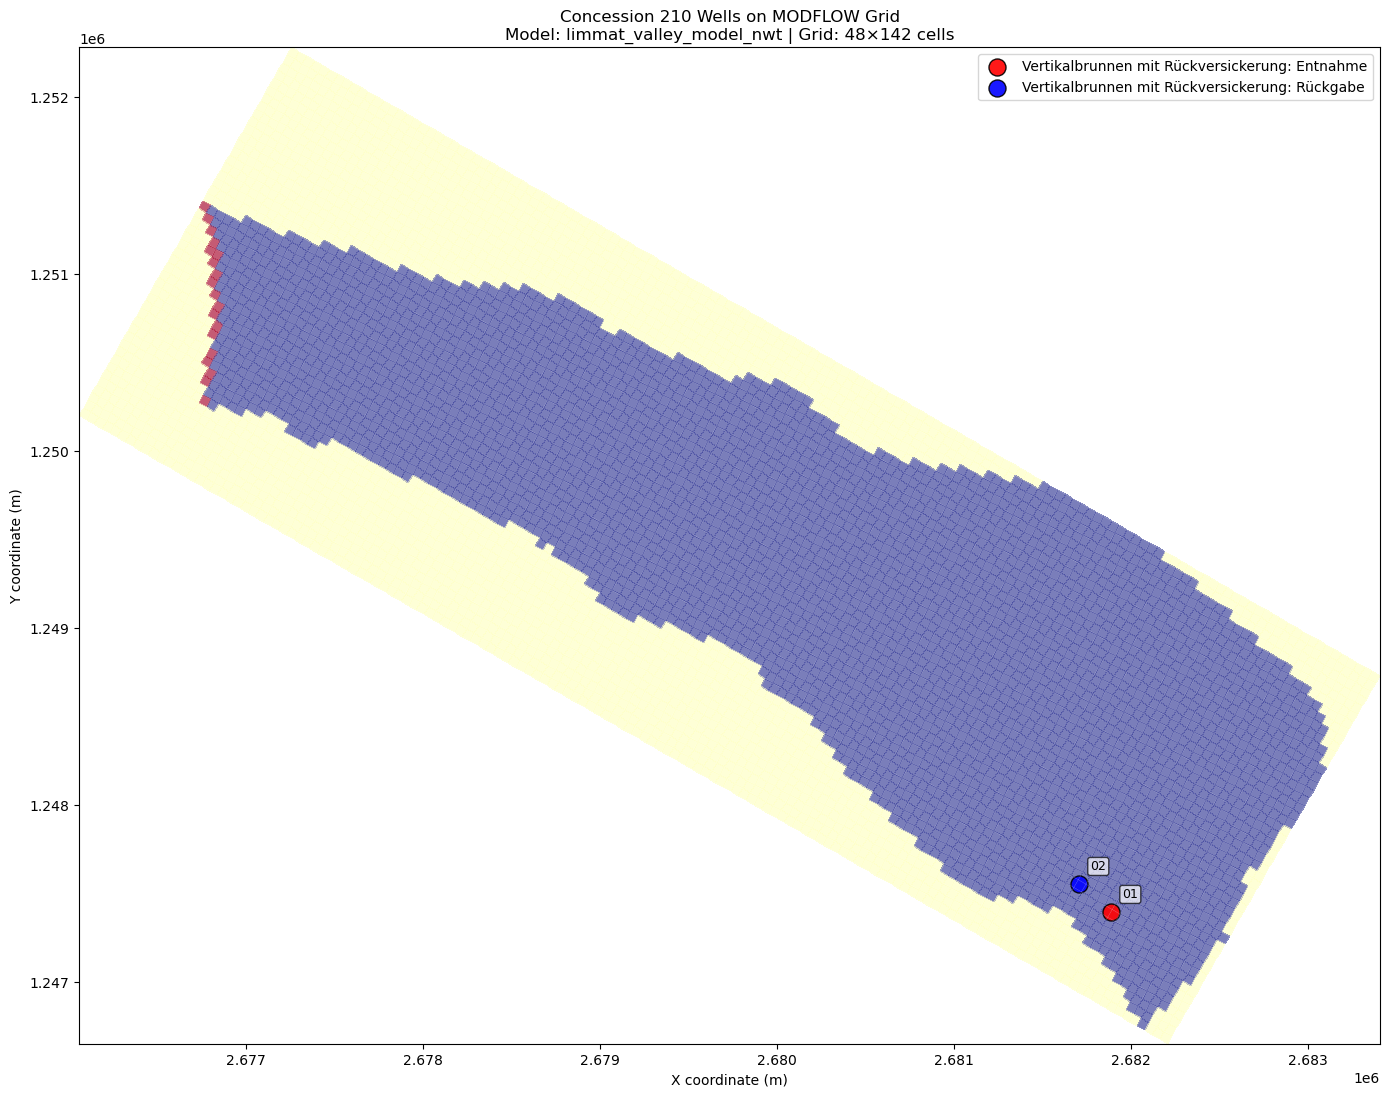

In [9]:
### 4.1 Get coordinates and well pumping rates
# Get the scenario option for this group
scenario = case_utils.get_scenario_for_group(CASE_YAML, group_number)
concession_id = scenario.get('concession', None)
if concession_id is None:
    raise ValueError(f"Concession ID not defined for group {group_number} in the scenario configuration.")

# Get well location data
well_data_path = download_named_file(name='wells', data_type='gis')
wells_gdf = gpd.read_file(well_data_path, layer='GS_GRUNDWASSERFASSUNGEN_OGD_P')

wells_gdf = case_utils.filter_wells_by_concession(wells_gdf, concession_id)
print(wells_gdf[['GWR_ID', 'GWR_PREFIX', 'FASSART']])

# First, let's check what coordinates your model grid is using
print("Model grid coordinate information:")
print(f"X range: {m.modelgrid.xcellcenters.min():.2f} to {m.modelgrid.xcellcenters.max():.2f}")
print(f"Y range: {m.modelgrid.ycellcenters.min():.2f} to {m.modelgrid.ycellcenters.max():.2f}")
print(f"Grid CRS: {m.modelgrid.crs}")
print(f"Grid rotation: {m.modelgrid.angrot} degrees")
print(f"Grid offset: ({m.modelgrid.xoffset}, {m.modelgrid.yoffset})")

# Check your wells coordinates
print(f"\nWells coordinate information:")
print(f"Wells CRS: {wells_gdf.crs}")
print(f"Wells X range: {wells_gdf.geometry.x.min():.2f} to {wells_gdf.geometry.x.max():.2f}")
print(f"Wells Y range: {wells_gdf.geometry.y.min():.2f} to {wells_gdf.geometry.y.max():.2f}")

# Load the modelgrid for rotated views
modelgrid_path = os.path.join(base_ws, f"{m.name}_modelgrid.pkl")
with open(modelgrid_path, 'rb') as f:
    modelgrid = pickle.load(f)

# Visualize the wells on the modelgrid
case_utils.plot_wells_on_model(m, modelgrid=modelgrid, wells_gdf=wells_gdf, 
                               concession_id=concession_id)

The concession 210 in the Limmat valley aquifer consists of 2 wells. One for abstraction (Entnahme) and one for injection (Rückgabe). 

We will now create a sub-model boundary polygon based on the following buffer distances from the wells:

In [51]:
# Buffer distances
buffer_downstream = 300  # meters
buffer_upstream = 50      # meters
buffer_south = 50         # meters
buffer_north = 50         # meters

# Add buffers to the concession geometry
concession_geom = wells_gdf.unary_union.convex_hull
concession_geom_buffered = concession_geom.buffer(buffer_downstream,
                                                  resolution=16,
                                                  cap_style=2,  # flat ends
                                                  join_style=2) # mitre corners
concession_geom_buffered = concession_geom_buffered.buffer(buffer_upstream,
                                                          resolution=16,
                                                          cap_style=2,
                                                          join_style=2)
concession_geom_buffered = concession_geom_buffered.buffer(buffer_south,
                                                          resolution=16,
                                                          cap_style=2,
                                                          join_style=2)
concession_geom_buffered = concession_geom_buffered.buffer(buffer_north,
                                                          resolution=16,
                                                          cap_style=2,
                                                          join_style=2)
print(f"Concession area (with buffers): {concession_geom_buffered.area:.1f} m²")
case_utils.plot_wells_on_model(m, modelgrid=modelgrid, wells_gdf=wells_gdf, 
                               concession_id=concession_id,
                               concession_geom=concession_geom_buffered)

Concession area (with buffers): 486234.0 m²


/var/folders/fx/fhbs7qgd6998fvtd5n8bs1lr0000gn/T/ipykernel_76611/2757553593.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  concession_geom = wells_gdf.unary_union.convex_hull
/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/shapely/decorators.py:102: DeprecationWarning: The 'resolution' argument is deprecated. Use 'quad_segs' instead
  ret_value = func(*args, **kwargs)
/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/shapely/decorators.py:102: DeprecationWarning: The 'resolution' argument is deprecated. Use 'quad_segs' instead
  ret_value = func(*args, **kwargs)
/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/shapely/decorators.py:102: DeprecationWarning: The 'resolution' argument is deprecated. Use 'quad_segs' instead
  ret_value = func(*args, **kwargs)
/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/shapely/decorators.py:1

TypeError: plot_wells_on_model() got an unexpected keyword argument 'concession_geom'

Submodel dimensions: 97 rows x 92 cols
Submodel bounds in real-world coordinates: (1247247.8414000012, 1247705.8429999985, 2681504.8960999995, 2681985.8944000006)
Available (timestep, stress_period) combinations: [(0, 0)]
Using last available record: (0, 0)
Successfully loaded heads from kstpkper: (0, 0)
Submodel cell bounds: rows 0-3, cols 0-3
Extracted 12 boundary cells
Submodel grid: 4 x 4


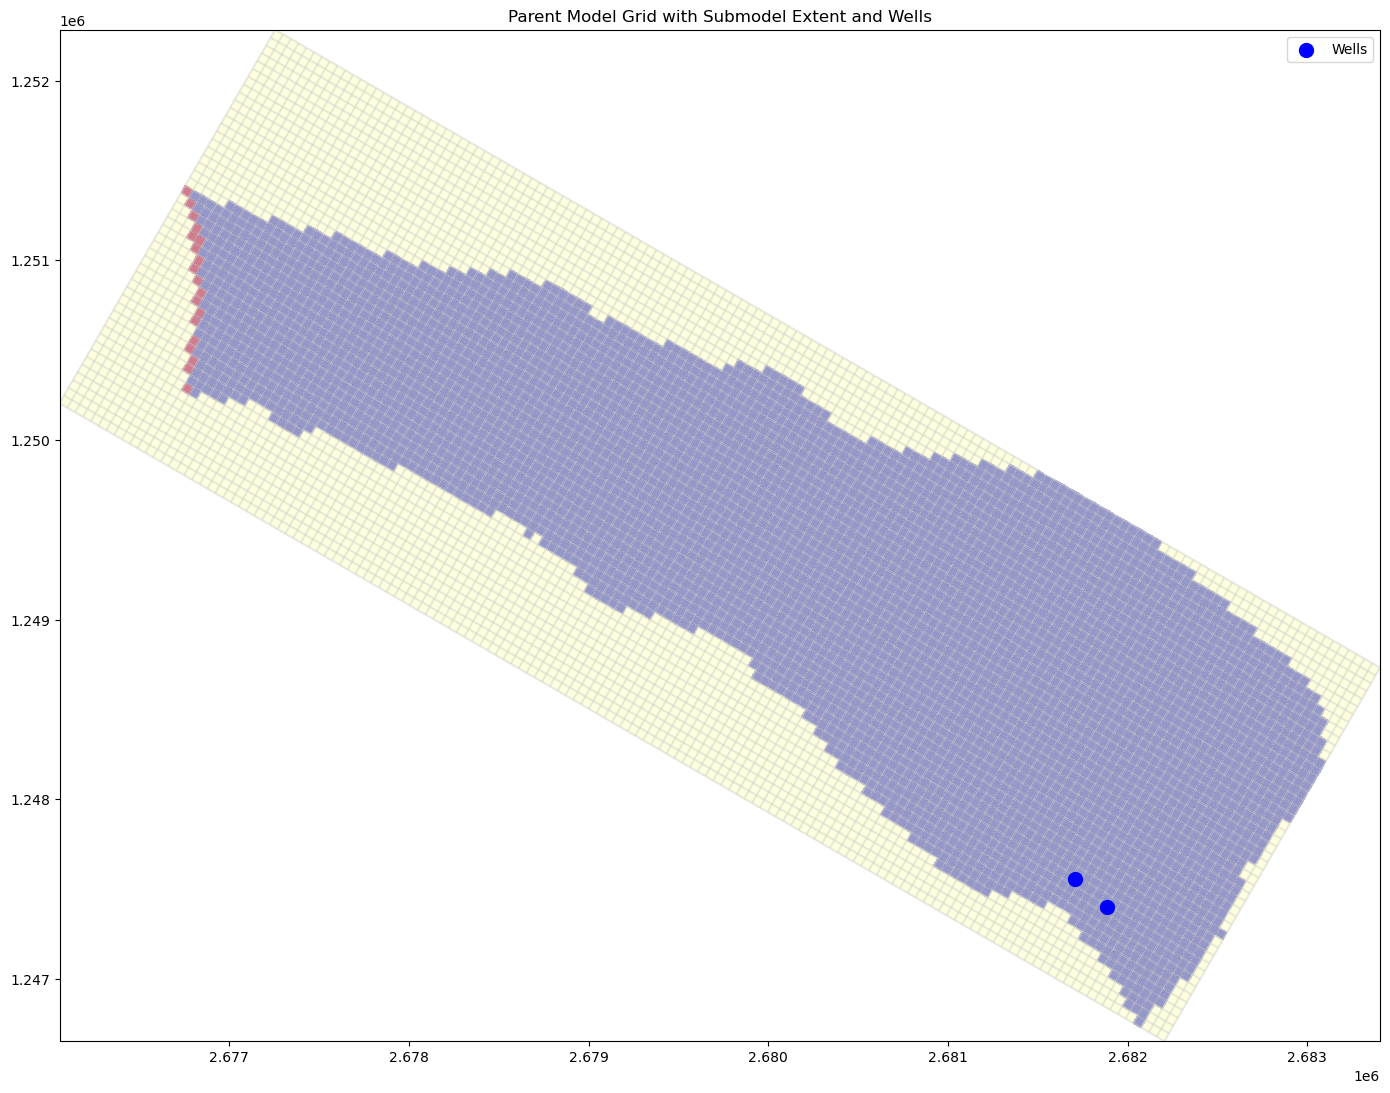

Submodel grid created successfully:
  Extent: 1247247.8 to 1247705.8 (X), 2681504.9 to 2681985.9 (Y)
  Cell size: 5 m
  Grid dimensions: 97 x 92
  Rotation: -30 degrees


In [33]:
### 4.2 Define sub-model grid and parameters
# Define submodel parameters
sub_nlay = 1  # Number of layers in submodel
lateral_distance_from_wells = 100  # meters
upstream_distance_from_wells = 50  # meters
downstream_distance_from_wells = 150  # meters
sub_cell_size = 5  # meters 
base_model_cell_size = m.modelgrid.delr[0]  # assuming square cells
# We buffer the submodel by 3 base-model-sized cells in each direction
buffer = base_model_cell_size

# Define submodel bounds (in model coordinates, distances from the wells)
submodel_bounds = (
    wells_gdf.geometry.y.min() - lateral_distance_from_wells - buffer,
    wells_gdf.geometry.y.max() + lateral_distance_from_wells + buffer,
    wells_gdf.geometry.x.min() - downstream_distance_from_wells - buffer,
    wells_gdf.geometry.x.max() + upstream_distance_from_wells + buffer
)
# Calculate the lower-left corner of the submodel
xmin, xmax, ymin, ymax = submodel_bounds

# Calculate submodel dimensions
sub_nrows = int(np.ceil((ymax - ymin) / sub_cell_size))
sub_ncols = int(np.ceil((xmax - xmin) / sub_cell_size))

print(f"Submodel dimensions: {sub_nrows} rows x {sub_ncols} cols")

print(f"Submodel bounds in real-world coordinates: {submodel_bounds}")

# Initialize extractor
head_file_path = os.path.join(m.model_ws, m.name + '.hds')
extractor = case_utils.BoundaryHeadExtractor(m, head_file_path)

# Load heads from parent model results
heads = extractor.load_heads()
    

# Extract boundary heads
boundary_info = extractor.extract_boundary_heads(
    submodel_bounds, 
    layers=[0],  # Extract first layer only, sinlgele layer model
    buffer_cells=3
)
    
# Get CHD package data
chd_data = extractor.create_chd_package_data(boundary_info['boundary_data'])
    
print(f"Extracted {len(chd_data)} boundary cells")
print(f"Submodel grid: {boundary_info['submodel_grid']['nrow']} x {boundary_info['submodel_grid']['ncol']}")

# Generate the submodel grid
submodel_grid = StructuredGrid(
    delr=sub_cell_size * np.ones(sub_ncols),
    delc=sub_cell_size * np.ones(sub_nrows),
    top=np.ones((sub_nrows, sub_ncols)) * 100,
    botm=np.ones((sub_nrows, sub_ncols)) * 90,  # Single layer model, 10m thick
    xoff=xmin,
    yoff=ymax,
    angrot=modelgrid.angrot,
    crs=m.modelgrid.crs
)

# Plot the parent model grid with submodel extent and wells
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 12))

# Plot parent model grid
pmv = flopy.plot.PlotMapView(model=m, modelgrid=modelgrid, ax=ax)
pmv.plot_grid(color='lightgrey', alpha=0.5)
pmv.plot_array(m.bas6.ibound.array, alpha=0.3, cmap='RdYlBu', vmin=-1, vmax=1)

# Plot submodel grid outline
submodel_pmv = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax)
submodel_pmv.plot_grid(color='red', linewidth=2, alpha=0.8)

# Plot wells
wells_gdf.plot(ax=ax, color='blue', markersize=100, label='Wells', zorder=5)

# Add submodel boundary rectangle for clarity
from matplotlib.patches import Rectangle
#rect = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
#                linewidth=3, edgecolor='red', facecolor='none', 
#                linestyle='--', label='Submodel Domain')
#ax.add_patch(rect)

ax.set_title('Parent Model Grid with Submodel Extent and Wells')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

print(f"Submodel grid created successfully:")
print(f"  Extent: {xmin:.1f} to {xmax:.1f} (X), {ymin:.1f} to {ymax:.1f} (Y)")
print(f"  Cell size: {sub_cell_size} m")
print(f"  Grid dimensions: {sub_nrows} x {sub_ncols}")
print(f"  Rotation: {submodel_grid.angrot} degrees")

# Plot the submodel grid
#case_utils.plot_submodel_extent_on_parent_model(m, modelgrid, wells_gdf, concession_id, submodel_bounds, submodel_grid)

Base model cell size: 50.0 m
Grid rotation: -30 degrees
Wells extent: X [2681704.9, 2681885.9], Y [1247397.8, 1247555.8]

Submodel bounds with all buffers:
  X direction: well extent (181.0 m) + downstream (300 m) + upstream (50 m) + 2×additional (100.0 m)
  Y direction: well extent (158.0 m) + south (50 m) + north (50 m) + 2×additional (100.0 m)
  Total X span: 631.0 m
  Total Y span: 358.0 m

Submodel bounds: X [2681354.9, 2681985.9], Y [1247297.8, 1247655.8]
Submodel dimensions: X = 631.0 m, Y = 358.0 m
Submodel grid dimensions: 72 rows x 127 cols
Expected aspect ratio (cols/rows): 1.76
Adjusted bounds: X [2681354.9, 2681989.9], Y [1247295.8, 1247655.8]
Well 46: (2681885.9, 1247397.8) -> Cell (L0, R38, C129)
Well 579: (2681704.9, 1247555.8) -> Cell (L0, R37, C124)
Total buffers: Row = 200.0 m, Col = 450.0 m
Corrected grid positioning:
  xoff: 2681354.9 (left edge)
  yoff: 1247655.8 (top edge)
  Submodel extent: X [2681354.9, 2681989.9], Y [1247295.8, 1247655.8]
Submodel cell bounds:

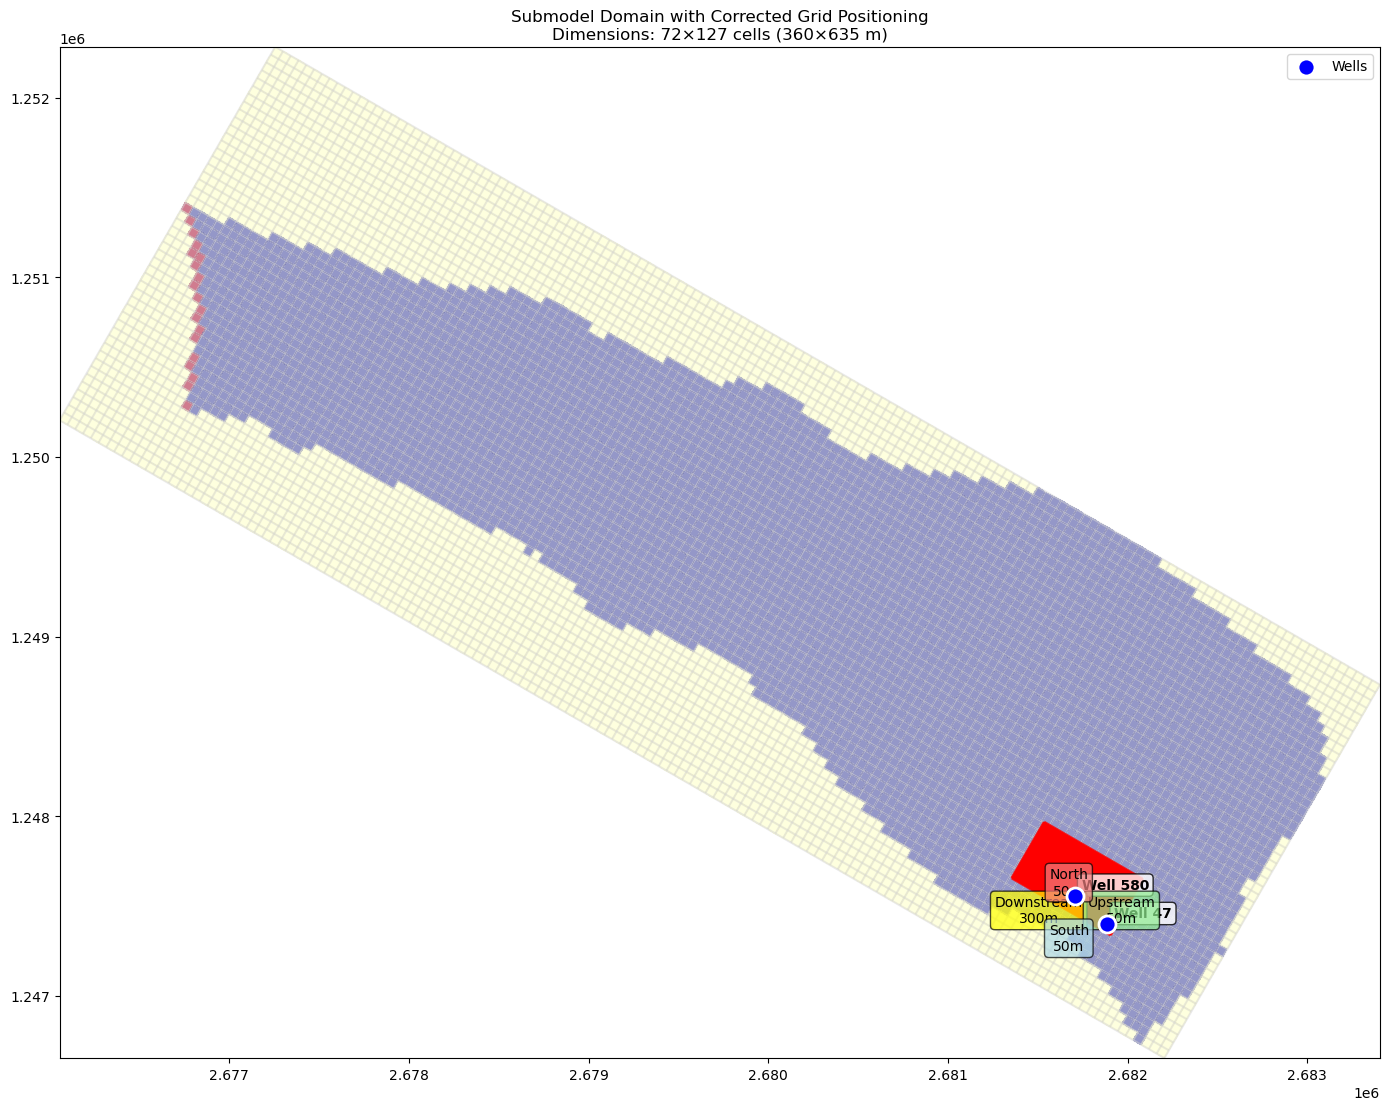


Submodel grid created successfully (corrected positioning):
  Extent: 2681354.9 to 2681989.9 (X), 1247295.8 to 1247655.8 (Y)
  Cell size: 5 m
  Grid dimensions: 72 rows x 127 cols
  Grid offset: (2681354.9, 1247655.8)
  Rotation: -30 degrees (same as parent)
  Refinement factor: 10.0×

Centering verification:
  Submodel center: (2681672.4, 1247475.8)


In [48]:
### 4.2 Define sub-model grid and parameters - CORRECTED BUFFER APPLICATION
import numpy as np
from flopy.utils.gridintersect import GridIntersect

# Define submodel parameters
sub_nlay = 1  # Number of layers in submodel
sub_cell_size = 5  # meters 
base_model_cell_size = modelgrid.delr[0]  # assuming square cells

# Define buffer distances in real-world units
downstream_buffer_m = 300  # 300 m buffer downstream
upstream_buffer_m = 50     # 50 m buffer upstream  
south_buffer_m = 50       # 50 m buffer south
north_buffer_m = 50       # 50 m buffer north

# Additional buffer for boundary extraction
additional_buffer = base_model_cell_size

print(f"Base model cell size: {base_model_cell_size} m")
print(f"Grid rotation: {modelgrid.angrot} degrees")

# Get well coordinates extent
well_x_min = wells_gdf.geometry.x.min()
well_x_max = wells_gdf.geometry.x.max()
well_y_min = wells_gdf.geometry.y.min()
well_y_max = wells_gdf.geometry.y.max()

print(f"Wells extent: X [{well_x_min:.1f}, {well_x_max:.1f}], Y [{well_y_min:.1f}, {well_y_max:.1f}]")

# Define submodel bounds with ALL buffers properly applied
# X direction: well extent + downstream buffer + upstream buffer + additional buffer on both sides
# Y direction: well extent + south buffer + north buffer + additional buffer on both sides

xmin = well_x_min - downstream_buffer_m - additional_buffer   # West (downstream)
xmax = well_x_max + upstream_buffer_m + additional_buffer     # East (upstream)
ymin = well_y_min - south_buffer_m - additional_buffer        # South  
ymax = well_y_max + north_buffer_m + additional_buffer        # North

print(f"\nSubmodel bounds with all buffers:")
print(f"  X direction: well extent ({well_x_max - well_x_min:.1f} m) + downstream ({downstream_buffer_m} m) + upstream ({upstream_buffer_m} m) + 2×additional ({2*additional_buffer} m)")
print(f"  Y direction: well extent ({well_y_max - well_y_min:.1f} m) + south ({south_buffer_m} m) + north ({north_buffer_m} m) + 2×additional ({2*additional_buffer} m)")
print(f"  Total X span: {xmax - xmin:.1f} m")  
print(f"  Total Y span: {ymax - ymin:.1f} m")

submodel_bounds = (xmin, xmax, ymin, ymax)

print(f"\nSubmodel bounds: X [{xmin:.1f}, {xmax:.1f}], Y [{ymin:.1f}, {ymax:.1f}]")
print(f"Submodel dimensions: X = {xmax-xmin:.1f} m, Y = {ymax-ymin:.1f} m")

# Calculate submodel dimensions
sub_nrows = int(np.ceil((ymax - ymin) / sub_cell_size))
sub_ncols = int(np.ceil((xmax - xmin) / sub_cell_size))

print(f"Submodel grid dimensions: {sub_nrows} rows x {sub_ncols} cols")
print(f"Expected aspect ratio (cols/rows): {sub_ncols/sub_nrows:.2f}")

# Adjust bounds to match exact grid dimensions (important for proper alignment)
actual_xmax = xmin + sub_ncols * sub_cell_size
actual_ymin = ymax - sub_nrows * sub_cell_size

print(f"Adjusted bounds: X [{xmin:.1f}, {actual_xmax:.1f}], Y [{actual_ymin:.1f}, {ymax:.1f}]")

# Step 1: Find grid cells containing wells using GridIntersect (for verification)
gi = GridIntersect(modelgrid, method='vertex')

well_cells = []
for idx, well in wells_gdf.iterrows():
    # Get well coordinates
    well_point = (well.geometry.x, well.geometry.y)
    
    # Find intersecting cell
    intersect_result = gi.intersect(well_point, shapetype='point')
    
    if len(intersect_result) > 0:
        result_info = intersect_result[0]
        
        # Extract cellids (using simplified approach)
        if hasattr(result_info, 'dtype') and result_info.dtype.names:
            if 'cellids' in result_info.dtype.names:
                cellids = result_info['cellids']
                if isinstance(cellids, (tuple, list, np.ndarray)) and len(cellids) >= 2:
                    row, col = int(cellids[0]), int(cellids[1])
                else:
                    row, col = int(cellids), int(cellids)
            else:
                row, col = int(result_info[0]), int(result_info[1])
        else:
            if isinstance(result_info, (tuple, list)) and len(result_info) >= 2:
                row, col = int(result_info[0]), int(result_info[1])
            else:
                # Fallback to manual lookup
                x, y = well.geometry.x, well.geometry.y
                distances = np.sqrt((modelgrid.xcellcenters - x)**2 + (modelgrid.ycellcenters - y)**2)
                min_idx = np.unravel_index(np.argmin(distances), distances.shape)
                row, col = min_idx[0], min_idx[1]
        
        layer = 0  # Single layer model
        
        well_cells.append({
            'well_idx': idx,
            'x': well.geometry.x,
            'y': well.geometry.y,
            'layer': layer,
            'row': row,
            'col': col
        })
        print(f"Well {idx}: ({well.geometry.x:.1f}, {well.geometry.y:.1f}) -> Cell (L{layer}, R{row}, C{col})")

if not well_cells:
    # Fallback: manual grid cell lookup
    print("GridIntersect failed, using manual cell lookup...")
    for idx, well in wells_gdf.iterrows():
        x, y = well.geometry.x, well.geometry.y
        distances = np.sqrt((modelgrid.xcellcenters - x)**2 + (modelgrid.ycellcenters - y)**2)
        min_idx = np.unravel_index(np.argmin(distances), distances.shape)
        row, col = min_idx[0], min_idx[1]
        layer = 0
        
        well_cells.append({
            'well_idx': idx,
            'x': x,
            'y': y,
            'layer': layer,
            'row': row,
            'col': col
        })
        print(f"Well {idx}: ({x:.1f}, {y:.1f}) -> Cell (L{layer}, R{row}, C{col}) [manual lookup]")

# Calculate total buffers for centering
total_row_buffer = north_buffer_m + south_buffer_m + 2 * additional_buffer
total_col_buffer = downstream_buffer_m + upstream_buffer_m + 2 * additional_buffer

print(f"Total buffers: Row = {total_row_buffer:.1f} m, Col = {total_col_buffer:.1f} m")

# Define submodel bounds with corrected centering logic
# X direction: center the submodel around wells, but shift east by upstream buffer amount
xoff_corrected = xmin - total_row_buffer/2  # FloPy uses top-left corner as reference
xoff_corrected = xmin
xmax_corrected = xoff_corrected + (sub_ncols * sub_cell_size)

# Y direction: center the submodel around wells, but shift by half the total row buffer
yoff_corrected = ymin + upstream_buffer_m  # FloPy uses top-left corner as reference
yoff_corrected = ymax
ymin_corrected = yoff_corrected - (sub_nrows * sub_cell_size)

print(f"Corrected grid positioning:")
print(f"  xoff: {xoff_corrected:.1f} (left edge)")
print(f"  yoff: {yoff_corrected:.1f} (top edge)")
print(f"  Submodel extent: X [{xoff_corrected:.1f}, {xmax_corrected:.1f}], Y [{ymin_corrected:.1f}, {yoff_corrected:.1f}]")

# Update submodel bounds for boundary extraction
submodel_bounds = (xoff_corrected, xmax_corrected, ymin_corrected, yoff_corrected)

# Extract boundary heads using the corrected bounds
boundary_info = extractor.extract_boundary_heads(
    submodel_bounds, 
    layers=[0],  # Extract first layer only, single layer model
    buffer_cells=3
)
    
# Get CHD package data
chd_data = extractor.create_chd_package_data(boundary_info['boundary_data'])
    
print(f"\nExtracted {len(chd_data)} boundary cells")
print(f"Boundary extraction grid: {boundary_info['submodel_grid']['nrow']} x {boundary_info['submodel_grid']['ncol']}")

# Generate the submodel grid with corrected offset
submodel_grid = StructuredGrid(
    delr=sub_cell_size * np.ones(sub_ncols),
    delc=sub_cell_size * np.ones(sub_nrows),
    top=np.ones((sub_nrows, sub_ncols)) * 100,
    botm=np.ones((sub_nrows, sub_ncols)) * 90,  # Single layer model, 10m thick
    xoff=xoff_corrected,  # Corrected left edge
    yoff=yoff_corrected,  # Corrected top edge (FloPy uses top-left as reference)
    angrot=modelgrid.angrot,  # IMPORTANT: Use same rotation as parent grid
    crs=m.modelgrid.crs
)

# Verify that wells are within the corrected submodel bounds
print(f"\nWell position verification (corrected bounds):")
for idx, well in wells_gdf.iterrows():
    x, y = well.geometry.x, well.geometry.y
    within_x = xoff_corrected <= x <= xmax_corrected
    within_y = ymin_corrected <= y <= yoff_corrected
    
    # Calculate distances to submodel edges
    dist_to_west = x - xoff_corrected
    dist_to_east = xmax_corrected - x
    dist_to_south = y - ymin_corrected  
    dist_to_north = yoff_corrected - y
    
    print(f"Well {well.get('GWR_ID', idx)}: ({x:.1f}, {y:.1f}) - Within bounds: X={within_x}, Y={within_y}")
    print(f"  Distances to edges: West={dist_to_west:.1f}m, East={dist_to_east:.1f}m, South={dist_to_south:.1f}m, North={dist_to_north:.1f}m")

# Plot the parent model grid with corrected submodel extent and wells
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 12))

# Plot parent model grid
pmv = flopy.plot.PlotMapView(model=m, modelgrid=modelgrid, ax=ax)
pmv.plot_grid(color='lightgrey', alpha=0.5)
pmv.plot_array(m.bas6.ibound.array, alpha=0.3, cmap='RdYlBu', vmin=-1, vmax=1)

# Plot submodel grid outline
submodel_pmv = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax)
submodel_pmv.plot_grid(color='red', linewidth=2, alpha=0.8)

# Plot wells with better visibility
wells_gdf.plot(ax=ax, color='blue', markersize=150, label='Wells', zorder=5, edgecolors='white', linewidth=2)

# Add well labels
for idx, well in wells_gdf.iterrows():
    ax.annotate(f"Well {idx+1}", 
                xy=(well.geometry.x, well.geometry.y), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Add buffer annotations for clarity (updated positions)
ax.annotate(f'Downstream\n{downstream_buffer_m}m', 
           xy=(xoff_corrected + downstream_buffer_m/2, (ymin_corrected+yoff_corrected)/2), 
           ha='center', va='center', fontsize=10, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

ax.annotate(f'Upstream\n{upstream_buffer_m}m', 
           xy=(xmax_corrected - upstream_buffer_m/2, (ymin_corrected+yoff_corrected)/2), 
           ha='center', va='center', fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

ax.annotate(f'North\n{north_buffer_m}m', 
           xy=((xoff_corrected+xmax_corrected)/2, yoff_corrected - north_buffer_m/2), 
           ha='center', va='center', fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

ax.annotate(f'South\n{south_buffer_m}m', 
           xy=((xoff_corrected+xmax_corrected)/2, ymin_corrected + south_buffer_m/2), 
           ha='center', va='center', fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

ax.set_title(f'Submodel Domain with Corrected Grid Positioning\nDimensions: {sub_nrows}×{sub_ncols} cells ({yoff_corrected-ymin_corrected:.0f}×{xmax_corrected-xoff_corrected:.0f} m)')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

print(f"\nSubmodel grid created successfully (corrected positioning):")
print(f"  Extent: {xoff_corrected:.1f} to {xmax_corrected:.1f} (X), {ymin_corrected:.1f} to {yoff_corrected:.1f} (Y)")
print(f"  Cell size: {sub_cell_size} m")
print(f"  Grid dimensions: {sub_nrows} rows x {sub_ncols} cols")
print(f"  Grid offset: ({submodel_grid.xoffset:.1f}, {submodel_grid.yoffset:.1f})")
print(f"  Rotation: {submodel_grid.angrot} degrees (same as parent)")
print(f"  Refinement factor: {base_model_cell_size/sub_cell_size}×")
print(f"\nCentering verification:")
print(f"  Submodel center: ({(xoff_corrected + xmax_corrected)/2:.1f}, {(ymin_corrected + yoff_corrected)/2:.1f})")


Base model cell size: 50.0 m
Grid rotation: -30 degrees
Buffer distances in cells:
  Downstream: 6 cells (300.0 m)
  Upstream: 1 cells (50.0 m)
  South: 1 cells (50.0 m)
  North: 1 cells (50.0 m)
Well 46: (2681885.9, 1247397.8) -> Cell (L0, R38, C129)
Well 579: (2681704.9, 1247555.8) -> Cell (L0, R37, C124)

Wells grid extent: rows [37, 38], cols [124, 129]
Submodel grid extent: rows [35, 40], cols [117, 131]
Corner coordinates:
  NW: (2681456.0, 1247807.7)
  NE: (2682062.2, 1247457.7)
  SW: (2681331.0, 1247591.2)
  SE: (2681937.2, 1247241.2)
Submodel real-world bounds (corrected):
  X: [2681306.0, 2682087.2]
  Y: [1247216.2, 1247832.7]
Submodel size (corrected): 781.2 m x 616.5 m
Submodel dimensions (corrected): 124 rows x 157 cols
Submodel size: 781.2 m x 616.5 m
Adjusted bounds: X [2681306.0, 2682091.0], Y [1247212.7, 1247832.7]
Available (timestep, stress_period) combinations: [(0, 0)]
Using last available record: (0, 0)
Successfully loaded heads from kstpkper: (0, 0)
Submodel cell

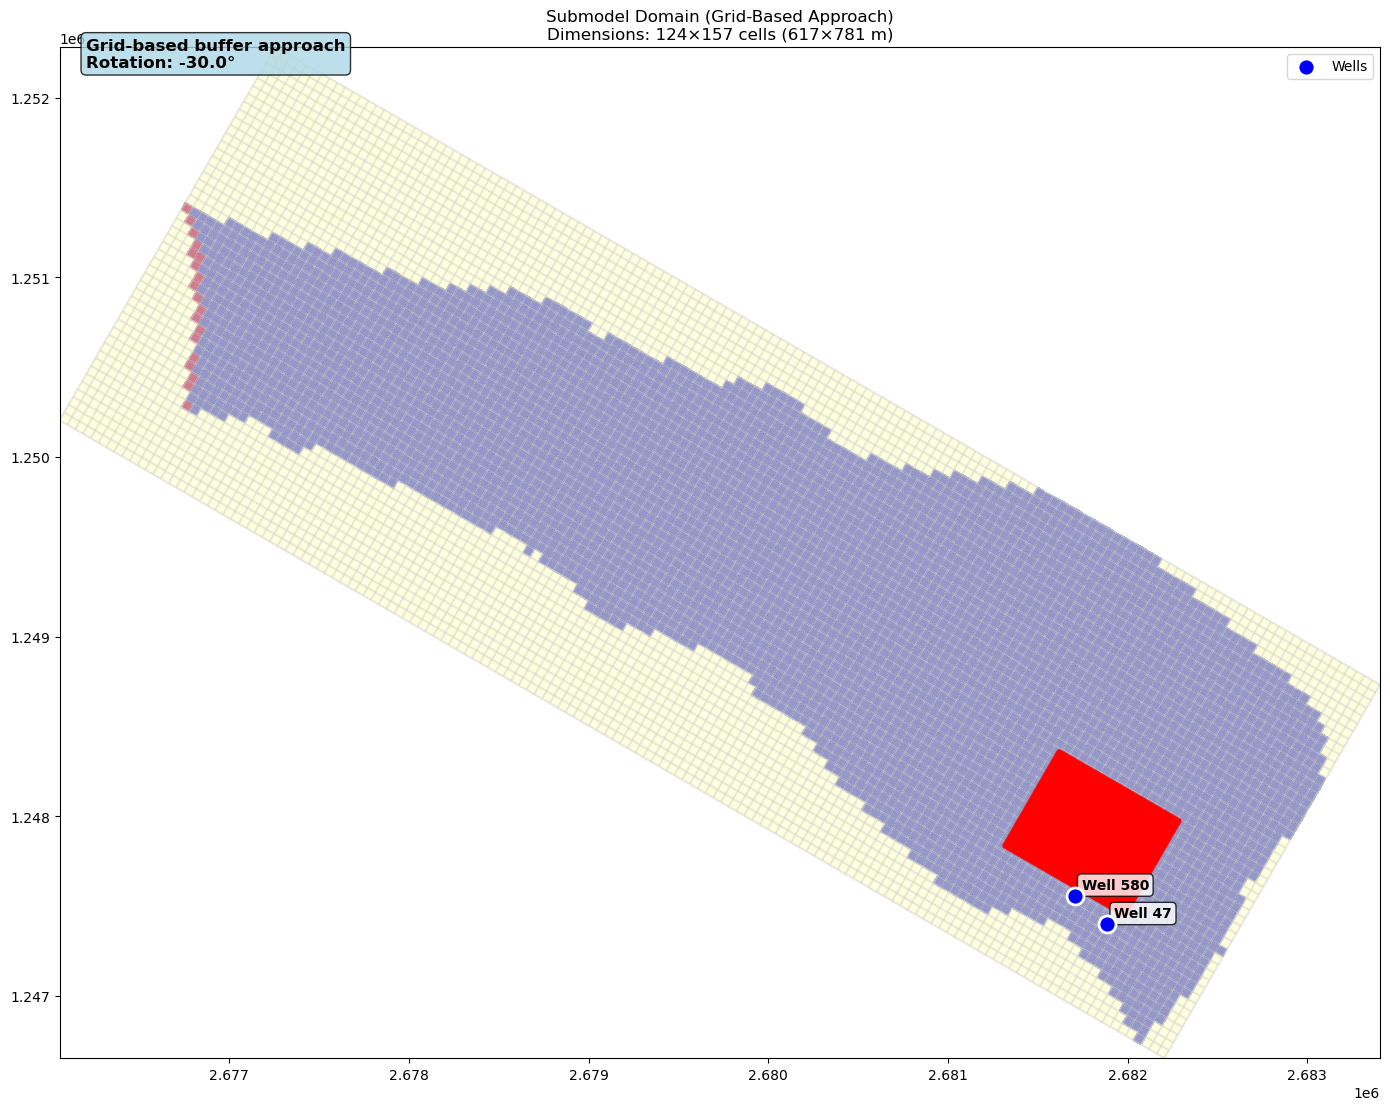


Submodel grid created successfully (grid-based approach):
  Extent: 2681306.0 to 2682091.0 (X), 1247212.7 to 1247832.7 (Y)
  Cell size: 5 m
  Grid dimensions: 124 rows x 157 cols
  Grid offset: (2681306.0, 1247832.7)
  Rotation: -30 degrees (same as parent)
  Refinement factor: 10.0×

Buffer verification (in parent grid cells):
  Wells span: 2 rows × 6 cols
  + Buffers: 4 rows × 9 cols
  = Total submodel coverage: 6 rows × 15 cols


In [50]:
### 4.2 Define sub-model grid and parameters - GRID-BASED APPROACH
import numpy as np
from flopy.utils.gridintersect import GridIntersect

# Define submodel parameters
sub_nlay = 1  # Number of layers in submodel
sub_cell_size = 5  # meters 
base_model_cell_size = modelgrid.delr[0]  # assuming square cells

# Define buffer distances in GRID CELLS (not meters)
downstream_buffer_cells = int(300 / base_model_cell_size)  # 300m / 50m = 6 cells
upstream_buffer_cells = int(50 / base_model_cell_size)     # 50m / 50m = 1 cell
south_buffer_cells = int(50 / base_model_cell_size)        # 50m / 50m = 1 cell  
north_buffer_cells = int(50 / base_model_cell_size)        # 50m / 50m = 1 cell
additional_buffer_cells = 1  # 1 cell buffer for boundary extraction

print(f"Base model cell size: {base_model_cell_size} m")
print(f"Grid rotation: {modelgrid.angrot} degrees")
print(f"Buffer distances in cells:")
print(f"  Downstream: {downstream_buffer_cells} cells ({downstream_buffer_cells * base_model_cell_size} m)")
print(f"  Upstream: {upstream_buffer_cells} cells ({upstream_buffer_cells * base_model_cell_size} m)")
print(f"  South: {south_buffer_cells} cells ({south_buffer_cells * base_model_cell_size} m)")
print(f"  North: {north_buffer_cells} cells ({north_buffer_cells * base_model_cell_size} m)")

# Step 1: Find grid cells containing wells
gi = GridIntersect(modelgrid, method='vertex')

well_cells = []
for idx, well in wells_gdf.iterrows():
    # Get well coordinates
    well_point = (well.geometry.x, well.geometry.y)
    
    # Find intersecting cell
    intersect_result = gi.intersect(well_point, shapetype='point')
    
    if len(intersect_result) > 0:
        result_info = intersect_result[0]
        
        # Extract cellids (using simplified approach)
        if hasattr(result_info, 'dtype') and result_info.dtype.names:
            if 'cellids' in result_info.dtype.names:
                cellids = result_info['cellids']
                if isinstance(cellids, (tuple, list, np.ndarray)) and len(cellids) >= 2:
                    row, col = int(cellids[0]), int(cellids[1])
                else:
                    row, col = int(cellids), int(cellids)
            else:
                row, col = int(result_info[0]), int(result_info[1])
        else:
            if isinstance(result_info, (tuple, list)) and len(result_info) >= 2:
                row, col = int(result_info[0]), int(result_info[1])
            else:
                # Fallback to manual lookup
                x, y = well.geometry.x, well.geometry.y
                distances = np.sqrt((modelgrid.xcellcenters - x)**2 + (modelgrid.ycellcenters - y)**2)
                min_idx = np.unravel_index(np.argmin(distances), distances.shape)
                row, col = min_idx[0], min_idx[1]
        
        layer = 0  # Single layer model
        
        well_cells.append({
            'well_idx': idx,
            'x': well.geometry.x,
            'y': well.geometry.y,
            'layer': layer,
            'row': row,
            'col': col
        })
        print(f"Well {idx}: ({well.geometry.x:.1f}, {well.geometry.y:.1f}) -> Cell (L{layer}, R{row}, C{col})")

if not well_cells:
    # Fallback: manual grid cell lookup
    print("GridIntersect failed, using manual cell lookup...")
    for idx, well in wells_gdf.iterrows():
        x, y = well.geometry.x, well.geometry.y
        distances = np.sqrt((modelgrid.xcellcenters - x)**2 + (modelgrid.ycellcenters - y)**2)
        min_idx = np.unravel_index(np.argmin(distances), distances.shape)
        row, col = min_idx[0], min_idx[1]
        layer = 0
        
        well_cells.append({
            'well_idx': idx,
            'x': x,
            'y': y,
            'layer': layer,
            'row': row,
            'col': col
        })
        print(f"Well {idx}: ({x:.1f}, {y:.1f}) -> Cell (L{layer}, R{row}, C{col}) [manual lookup]")

# Step 2: Find extent of wells in grid cell indices
well_rows = [cell['row'] for cell in well_cells]
well_cols = [cell['col'] for cell in well_cells]

min_row = min(well_rows)
max_row = max(well_rows)
min_col = min(well_cols)
max_col = max(well_cols)

print(f"\nWells grid extent: rows [{min_row}, {max_row}], cols [{min_col}, {max_col}]")

# Step 3: Apply buffers in grid coordinates
# In a rotated grid:
# - "upstream" typically means increasing column index (towards positive X in grid space)
# - "downstream" means decreasing column index (towards negative X in grid space)  
# - "north" might mean decreasing row index (towards positive Y in grid space)
# - "south" might mean increasing row index (towards negative Y in grid space)

submodel_min_row = min_row - north_buffer_cells - additional_buffer_cells
submodel_max_row = max_row + south_buffer_cells + additional_buffer_cells
submodel_min_col = min_col - downstream_buffer_cells - additional_buffer_cells  
submodel_max_col = max_col + upstream_buffer_cells + additional_buffer_cells

print(f"Submodel grid extent: rows [{submodel_min_row}, {submodel_max_row}], cols [{submodel_min_col}, {submodel_max_col}]")

# Step 4: Convert grid indices back to real-world coordinates - CORRECTED
# Use the parent model grid to get the real-world coordinates of our submodel corners

# For the corners, we need to be careful about which corner corresponds to which grid index
# In a structured grid with rotation:
# - submodel_min_row corresponds to the northernmost edge (higher Y values)
# - submodel_max_row corresponds to the southernmost edge (lower Y values)
# - submodel_min_col corresponds to the westernmost edge (lower X values) 
# - submodel_max_col corresponds to the easternmost edge (higher X values)

# Get the cell centers for the corner cells
nw_corner_x = modelgrid.xcellcenters[submodel_min_row, submodel_min_col]  # Northwest corner
nw_corner_y = modelgrid.ycellcenters[submodel_min_row, submodel_min_col]

ne_corner_x = modelgrid.xcellcenters[submodel_min_row, submodel_max_col]  # Northeast corner
ne_corner_y = modelgrid.ycellcenters[submodel_min_row, submodel_max_col]

sw_corner_x = modelgrid.xcellcenters[submodel_max_row, submodel_min_col]  # Southwest corner
sw_corner_y = modelgrid.ycellcenters[submodel_max_row, submodel_min_col]

se_corner_x = modelgrid.xcellcenters[submodel_max_row, submodel_max_col]  # Southeast corner
se_corner_y = modelgrid.ycellcenters[submodel_max_row, submodel_max_col]

# Calculate the actual bounds of the submodel (accounting for cell extents)
# We want the bounds to include half a cell beyond the cell centers
half_cell = base_model_cell_size / 2

# Find the min/max coordinates across all corners and adjust by half cell size
all_x_coords = [nw_corner_x, ne_corner_x, sw_corner_x, se_corner_x]
all_y_coords = [nw_corner_y, ne_corner_y, sw_corner_y, se_corner_y]

submodel_xmin = min(all_x_coords) - half_cell
submodel_xmax = max(all_x_coords) + half_cell
submodel_ymin = min(all_y_coords) - half_cell
submodel_ymax = max(all_y_coords) + half_cell

print(f"Corner coordinates:")
print(f"  NW: ({nw_corner_x:.1f}, {nw_corner_y:.1f})")
print(f"  NE: ({ne_corner_x:.1f}, {ne_corner_y:.1f})")
print(f"  SW: ({sw_corner_x:.1f}, {sw_corner_y:.1f})")
print(f"  SE: ({se_corner_x:.1f}, {se_corner_y:.1f})")

print(f"Submodel real-world bounds (corrected):")
print(f"  X: [{submodel_xmin:.1f}, {submodel_xmax:.1f}]")
print(f"  Y: [{submodel_ymin:.1f}, {submodel_ymax:.1f}]")

# Step 5: Calculate submodel grid dimensions
submodel_width = submodel_xmax - submodel_xmin
submodel_height = submodel_ymax - submodel_ymin

print(f"Submodel size (corrected): {submodel_width:.1f} m x {submodel_height:.1f} m")

# Now both should be positive
if submodel_width <= 0 or submodel_height <= 0:
    print("WARNING: Still getting negative dimensions. Check grid orientation and corner calculation.")
    print(f"Width: {submodel_width:.1f} m, Height: {submodel_height:.1f} m")
else:
    sub_ncols = int(np.ceil(submodel_width / sub_cell_size))
    sub_nrows = int(np.ceil(submodel_height / sub_cell_size))

    print(f"Submodel dimensions (corrected): {sub_nrows} rows x {sub_ncols} cols")
    print(f"Submodel size: {submodel_width:.1f} m x {submodel_height:.1f} m")

    # Step 6: Adjust bounds to match exact grid dimensions
    actual_xmax = submodel_xmin + sub_ncols * sub_cell_size
    actual_ymin = submodel_ymax - sub_nrows * sub_cell_size

    print(f"Adjusted bounds: X [{submodel_xmin:.1f}, {actual_xmax:.1f}], Y [{actual_ymin:.1f}, {submodel_ymax:.1f}]")

    # Continue with the rest of the code...
    submodel_bounds = (submodel_xmin, actual_xmax, actual_ymin, submodel_ymax)

    # Initialize extractor
    head_file_path = os.path.join(m.model_ws, m.name + '.hds')
    extractor = case_utils.BoundaryHeadExtractor(m, head_file_path, modelgrid=modelgrid)

    # Load heads from parent model results
    heads = extractor.load_heads()

    # Extract boundary heads using the bounds
    boundary_info = extractor.extract_boundary_heads(
        submodel_bounds, 
        layers=[0],  # Extract first layer only, single layer model
        buffer_cells=3
    )
        
    # Get CHD package data
    chd_data = extractor.create_chd_package_data(boundary_info['boundary_data'])
        
    print(f"\nExtracted {len(chd_data)} boundary cells")
    print(f"Boundary extraction grid: {boundary_info['submodel_grid']['nrow']} x {boundary_info['submodel_grid']['ncol']}")

    # Step 8: Generate the submodel grid
    submodel_grid = StructuredGrid(
        delr=sub_cell_size * np.ones(sub_ncols),
        delc=sub_cell_size * np.ones(sub_nrows),
        top=np.ones((sub_nrows, sub_ncols)) * 100,
        botm=np.ones((sub_nrows, sub_ncols)) * 90,  # Single layer model, 10m thick
        xoff=submodel_xmin,  # Left edge of submodel
        yoff=submodel_ymax,  # Top edge of submodel (FloPy uses top-left as reference)
        angrot=modelgrid.angrot,  # IMPORTANT: Use same rotation as parent grid
        crs=m.modelgrid.crs
    )

    # Step 9: Verify that wells are within the submodel bounds
    print(f"\nWell position verification:")
    for idx, well in wells_gdf.iterrows():
        x, y = well.geometry.x, well.geometry.y
        within_x = submodel_xmin <= x <= actual_xmax
        within_y = actual_ymin <= y <= submodel_ymax
        
        # Calculate distances to submodel edges in the rotated coordinate system
        dist_to_west = x - submodel_xmin
        dist_to_east = actual_xmax - x
        dist_to_south = y - actual_ymin  
        dist_to_north = submodel_ymax - y
        
        print(f"Well {well.get('GWR_ID', idx)}: ({x:.1f}, {y:.1f}) - Within bounds: X={within_x}, Y={within_y}")
        print(f"  Distances to edges: West={dist_to_west:.1f}m, East={dist_to_east:.1f}m, South={dist_to_south:.1f}m, North={dist_to_north:.1f}m")

# Step 10: Plot the results
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 12))

# Plot parent model grid
pmv = flopy.plot.PlotMapView(model=m, modelgrid=modelgrid, ax=ax)
pmv.plot_grid(color='lightgrey', alpha=0.5)
pmv.plot_array(m.bas6.ibound.array, alpha=0.3, cmap='RdYlBu', vmin=-1, vmax=1)

# Plot submodel grid outline
submodel_pmv = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax)
submodel_pmv.plot_grid(color='red', linewidth=2, alpha=0.8)

# Plot wells with better visibility
wells_gdf.plot(ax=ax, color='blue', markersize=150, label='Wells', zorder=5, edgecolors='white', linewidth=2)

# Add well labels
for idx, well in wells_gdf.iterrows():
    ax.annotate(f"Well {idx+1}", 
                xy=(well.geometry.x, well.geometry.y), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Add grid information
ax.annotate(f'Grid-based buffer approach\nRotation: {modelgrid.angrot:.1f}°', 
           xy=(0.02, 0.98), xycoords='axes fraction',
           fontsize=12, fontweight='bold',
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))

ax.set_title(f'Submodel Domain (Grid-Based Approach)\nDimensions: {sub_nrows}×{sub_ncols} cells ({submodel_height:.0f}×{submodel_width:.0f} m)')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

print(f"\nSubmodel grid created successfully (grid-based approach):")
print(f"  Extent: {submodel_xmin:.1f} to {actual_xmax:.1f} (X), {actual_ymin:.1f} to {submodel_ymax:.1f} (Y)")
print(f"  Cell size: {sub_cell_size} m")
print(f"  Grid dimensions: {sub_nrows} rows x {sub_ncols} cols")
print(f"  Grid offset: ({submodel_grid.xoffset:.1f}, {submodel_grid.yoffset:.1f})")
print(f"  Rotation: {submodel_grid.angrot} degrees (same as parent)")
print(f"  Refinement factor: {base_model_cell_size/sub_cell_size}×")
print(f"\nBuffer verification (in parent grid cells):")
print(f"  Wells span: {max_row - min_row + 1} rows × {max_col - min_col + 1} cols")
print(f"  + Buffers: {north_buffer_cells + south_buffer_cells + 2*additional_buffer_cells} rows × {downstream_buffer_cells + upstream_buffer_cells + 2*additional_buffer_cells} cols")  
print(f"  = Total submodel coverage: {submodel_max_row - submodel_min_row + 1} rows × {submodel_max_col - submodel_min_col + 1} cols")

## 5. Scenario edits (from YAML): wells, recharge patches, river tweaks, parameter multipliers
Keep scenario small and clearly documented.


In [ ]:
# Wells
wel_cfg = cfg['stresses'].get('wells', {})
wel = m.get_package('WEL')
if wel_cfg and wel_cfg.get('entries'):
    entries = wel_cfg['entries']
    mode = wel_cfg.get('mode', 'replace').lower()
    arr = recarray_from_wells(entries)
    if wel is None:
        wel = flopy.modflow.ModflowWel(m, stress_period_data={0: arr})
        print('Created WEL with', len(entries), 'entries')
    else:
        if mode == 'append':
            old = wel.stress_period_data
            base = old[0] if 0 in old else list(old.data.values())[0]
            merged = np.concatenate([base, arr])
            wel.stress_period_data = {0: merged}
            print('Appended wells; total entries:', len(merged))
        else:
            wel.stress_period_data = {0: arr}
            print('Replaced wells with', len(entries), 'entries')
else:
    print('No new wells specified.')

# Recharge
rch_cfg = cfg['stresses'].get('recharge', {})
rch = m.get_package('RCH')
if rch is not None and rch_cfg:
    base_r = rch.rech.array
    if isinstance(base_r, list):
        base_r = base_r[0]
    base_r = np.array(base_r, dtype=float)
    scale = float(rch_cfg.get('scale', 1.0))
    base_r *= scale
    # patches (optional)
    for p in rch_cfg.get('patches', []):
        if p.get('kind','rect') == 'rect':
            r0,r1 = int(p['row_min']), int(p['row_max'])
            c0,c1 = int(p['col_min']), int(p['col_max'])
            base_r[r0:r1+1, c0:c1+1] *= float(p.get('factor', 1.0))
    rch.rech = base_r
    print('Recharge edited. New mean R:', float(np.mean(base_r)))
else:
    print('No recharge edits.')

# Rivers
riv_cfg = cfg['stresses'].get('rivers', {})
riv = m.get_package('RIV')
if riv is not None and riv_cfg:
    spd = riv.stress_period_data
    key0 = 0 if 0 in spd else list(spd.data.keys())[0]
    arr = spd[key0].copy()
    if 'stage_offset' in riv_cfg:
        arr['stage'] = arr['stage'] + float(riv_cfg['stage_offset'])
    if 'conductance_factor' in riv_cfg:
        arr['cond']  = arr['cond']  * float(riv_cfg['conductance_factor'])
    riv.stress_period_data = {0: arr}
    print('RIV edits applied')
else:
    print('No river edits.')

# Parameter multipliers
par = cfg.get('parameters', {})
lpf = m.get_package('LPF')
if lpf is not None:
    if 'hk_factor' in par and hasattr(lpf, 'hk'):
        lpf.hk = np.array(lpf.hk.array, dtype=float) * float(par['hk_factor'])
    if 'vk_factor' in par:
        if hasattr(lpf, 'vka') and lpf.vka is not None:
            lpf.vka = np.array(lpf.vka.array, dtype=float) * float(par['vk_factor'])
        elif hasattr(lpf, 'vk') and lpf.vk is not None:
            lpf.vk  = np.array(lpf.vk.array,  dtype=float) * float(par['vk_factor'])
print('Scenario edits complete.')


## 6. Scenario run
Now write inputs and run the scenario in the case workspace.

In [ ]:
m.write_input()
success, buff = m.run_model(report=True)
print('Scenario success:', success)
if not success:
    print('\n'.join(buff[-60:]))

lst_path = os.path.join(m.model_ws, m.name + '.lst')
hds_path = os.path.join(m.model_ws, m.name + '.hds')
cbc_path = os.path.join(m.model_ws, m.name + '.cbc')
print('Outputs:', lst_path, hds_path, cbc_path)

hf = HeadFile(hds_path)
H = hf.get_data()[-1]
print('Scenario heads shape:', H.shape)


## 7. Standard outputs
Produce a head map (layer 1), a **drawdown map** (scenario − baseline), sampled heads, and a compact water budget. These are required in every report.

In [ ]:
# Head map (layer 1)
plt.figure()
plt.imshow(H[0], origin='lower')
plt.colorbar(label='Head (m)')
plt.title('Scenario Heads — Layer 1')
plt.xlabel('col'); plt.ylabel('row')
plt.show()

# Drawdown map vs baseline
DD = H[0] - H_base[0]
plt.figure()
plt.imshow(DD, origin='lower')
plt.colorbar(label='Drawdown (m)')
plt.title('Drawdown (Scenario − Baseline) — Layer 1')
plt.xlabel('col'); plt.ylabel('row')
plt.show()

# Head samples
lrc = cfg['observations'].get('heads_lrc', [])
samples_base = [{'k':k,'i':i,'j':j,'head': float(H_base[k,i,j])} for (k,i,j) in lrc]
samples_scen = [{'k':k,'i':i,'j':j,'head': float(H[k,i,j])} for (k,i,j) in lrc]
print('Observation heads (baseline vs scenario):')
for sb, ss in zip(samples_base, samples_scen):
    dh = ss['head'] - sb['head']
    print(f"(k,i,j)=({sb['k']},{sb['i']},{sb['j']})  H_base={sb['head']:.3f}  H_scen={ss['head']:.3f}  dH={dh:.3f}")

# Budget summary
terms = cfg['observations'].get('budget_terms', [])
bud = summarize_budget(cbc_path, terms, kstpkper=(0,0)) if terms else {}
print('\nBudget summary (sum over cells, SP0/TS0):')
for k,v in bud.items():
    print(f'  {k:>16}: {v}')


## 8. Analytical check (required)
Compare your modeled drawdown to a simple analytical expectation at a chosen observation radius; document assumptions.

In [ ]:
ap = cfg['analysis_plan']
method = ap.get('method', 'Thiem_confined')
Q_abs = float(ap.get('Q_abs_m3d', 0.0))
r_obs = float(ap.get('r_obs_m', 1.0))
r_ref = float(ap.get('r_ref_m', 0.1))
if method == 'Thiem_confined':
    T = float(ap.get('T_m2d', 1.0))
    s_thiem = thiem_confined_drawdown(Q_abs, T, r_obs, r_ref)
    print('Thiem confined drawdown (m):', s_thiem)
else:
    # Simple Dupuit-like approximation if desired
    K = float(ap.get('K_mpd', 10.0))
    b = float(ap.get('b_m', 50.0))
    T = K * b
    s_thiem = thiem_confined_drawdown(Q_abs, T, r_obs, r_ref)
    print('Dupuit (using T=K*b) drawdown (m):', s_thiem)

print('Reminder: choose an observation point near r_obs for comparison and discuss discrepancies.')


## 9. Interpretation (write here)
**Required bullets:**
- Brief restatement of the question and key assumptions
- Head/drawdown patterns and physical interpretation
- River/well budget changes and stream depletion fraction (if applicable)
- Comparison to analytical expectation (agree? why/why not?)
- One sensitivity (e.g., halve/double K or river conductance) — describe the effect qualitatively/quantitatively


## 10. Checklist for submission
- [ ] `case_config.yaml` filled (no TODOs)
- [ ] Notebook runs top-to-bottom without errors
- [ ] Required figures: head map, drawdown map
- [ ] Observation heads table
- [ ] Budget summary table
- [ ] Analytical check with clearly stated parameters
- [ ] 1–2 paragraph interpretation & sensitivity notes


In [ ]:
# 1. Load YAML configuration
import yaml, re, pathlib, pandas as pd
from datetime import datetime
from pprint import pprint

CONFIG_PATH = pathlib.Path('case_config.yaml')  # adjusted after rename
with CONFIG_PATH.open() as f:
    cfg = yaml.safe_load(f)

print('Loaded config name:', cfg.get('name'))
print('Group number:', cfg.get('group', {}).get('number'))
print('Chosen scenario:', cfg.get('group', {}).get('chosen_scenario'))
print('Concession number:', cfg.get('group', {}).get('concession_number'))

# Basic validation
errors = []
if cfg['group']['chosen_scenario'] == 'SC10' and cfg['group']['concession_number'] == 138:
    errors.append('Scenario SC10 cannot be combined with concession 138. Choose a different scenario.')
if errors:
    raise ValueError('\n'.join(errors))

# 2. Define pattern for concession wells (example for 138)
concession_number = int(cfg['group']['concession_number'])
pattern = fr"^n010{concession_number:03d}_"  # e.g. n010138_*
print('Using GWR_ID regex pattern:', pattern)

# 3. Load concession wells source data (students: set the correct path)
# Expect a CSV with at least columns: GWR_ID, X, Y, RATE_M3D (negative extraction), BESCHREIBUNG
CONCESSION_CSV = pathlib.Path('./data/concessions_wells.csv')  # TODO: provide file
if not CONCESSION_CSV.exists():
    print('WARNING: concession CSV not found at', CONCESSION_CSV)
else:
    wells_raw = pd.read_csv(CONCESSION_CSV)
    wells_sel = wells_raw[wells_raw['GWR_ID'].str.match(pattern, na=False)].copy()
    print(f'Selected {len(wells_sel)} wells for concession {concession_number}')
    display(wells_sel.head())

# Placeholder: Validate pumping rates against BESCHREIBUNG bounds (students implement parsing logic)
# Example assumption: BESCHREIBUNG contains a numeric range like '0-1500 m3/d'
rate_issues = []
if 'BESCHREIBUNG' in locals().get('wells_sel', wells_sel).columns:
    rng_re = re.compile(r'(\d+)\s*[-–]\s*(\d+)')
    for _, row in wells_sel.iterrows():
        desc = str(row.get('BESCHREIBUNG', ''))
        m = rng_re.search(desc)
        if m:
            lo, hi = map(float, m.groups())
            rate = abs(row.get('RATE_M3D', 0))
            if not (lo <= rate <= hi):
                rate_issues.append((row['GWR_ID'], rate, (lo, hi)))
if rate_issues:
    print('Rate issues (outside BESCHREIBUNG range):')
    for gwid, rate, (lo, hi) in rate_issues:
        print(f'  {gwid}: {rate} not in [{lo}, {hi}]')
else:
    print('No rate range issues detected (or unable to parse ranges).')

# 4. Snap wells to model grid (students: implement using existing utilities if available)
# from SUPPORT_REPO.src.grid_utils import locate_cells  # hypothetical helper
# wells_sel['layer'] = 0  # TODO
# wells_sel['row'] = ...
# wells_sel['col'] = ...

# 5. Prepare pumping variants
# Full rates
# Half rates variant = wells_sel with RATE_M3D * 0.5
if 'wells_sel' in locals():
    wells_half = wells_sel.copy()
    if 'RATE_M3D' in wells_half.columns:
        wells_half['RATE_M3D'] *= 0.5

# 6. Apply scenario adjustments (outline only)
scenario = cfg['group']['chosen_scenario']
print('Scenario logic placeholder for:', scenario)
# if scenario == 'SC10':
#     ... (already blocked for concession 138) ...
# elif scenario == 'SC1':
#     conductance_factor = 1.2
# etc.

# 7. Run model variants (students integrate with modeling workflow / flopy)
# run_model(variant='full')
# run_model(variant='half')
# run_model(variant='full_scenario')
# run_model(variant='half_scenario')

# 8. Collect outputs into DataFrames / arrays for analysis
# heads_full = ...
# heads_half = ...
# delta_full = heads_full - heads_baseline
# river_leakage_changes = ...

# 9. Compute metrics (example placeholders)
# metrics = {
#   'max_drawdown_full_m': float(np.nanmax(baseline_heads - heads_full)),
#   'river_leakage_change_full_m3d': total_river_leakage_full - total_river_leakage_baseline,
# }
# pprint(metrics)

# 10. Save run log
log = {
    'timestamp': datetime.utcnow().isoformat() + 'Z',
    'group_number': cfg['group']['number'],
    'concession_number': concession_number,
    'scenario': scenario,
    'excluded_combo_blocked': (scenario == 'SC10' and concession_number == 138)
}
print('Run log (partial):')
print(log)

## Implementation Plan (Group Template)

Fill out and adapt this plan. NOTE: The combination of scenario SC10 (Both rivers leakage decreased -30%) with concession number 138 (wells GWR_ID like `n010138_*`) is NOT allowed; choose a different scenario if you have concession 138.

### Step Outline
1. Load configuration from your updated `case_config.yaml` (ensure `group.number`, `concession_number`, and `chosen_scenario` are set and valid).
2. Load baseline model from `~/applied_groundwater_modelling_data/limmat/limmat_valley_model` (read-only usage).
3. Import concession well data and filter rows for your concession number (e.g. 138) using GWR_ID pattern matching (`n010138_*`).
4. Map each concession well to model layer/row/column (snap to active cell); store in a structured DataFrame.
5. Run Model Variant A: full concession pumping rates.
6. Run Model Variant B: half concession pumping rates (rate * 0.5, maintain sign).
7. Apply chosen scenario parameter/stress modification (skip if invalid combination). For disallowed combination (SC10 + 138) raise a clear error and stop.
8. Re-run (or clone) simulations for scenario-adjusted conditions (full & half pumping if required by `pumping_rate_mode`).
9. Collect results: heads, drawdown relative to baseline, river leakage terms, cell-by-cell flows, budgets.
10. Compute evaluation metrics you defined (max drawdown, river leakage change, etc.).
11. Produce figures: head maps, drawdown difference (full vs baseline, half vs baseline), river leakage bar chart, budget comparison table, longitudinal profiles if relevant.
12. Summarize findings (2–3 paragraphs) interpreting physical significance and management implications.

### Data & Integrity Checks
- Confirm mass balance error < 0.5%.
- Ensure no dry cells appear unexpectedly (or document why if they do).
- Verify that parameter multipliers stay within reasonable bounds.
- Log all run configurations (JSON or YAML snapshot) for reproducibility.

Proceed to the code scaffolding cells below and complete them.
